In [77]:
import random
import librosa
import librosa.display
import scipy
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import IPython.display as ipd
import cv2
import soundfile as sf





# import torch
# import torchaudio
# from torchaudio import transforms
%matplotlib inline

In [73]:
n_fft = 1024

def fourier(signal):
    fourier = librosa.stft(signal, n_fft=n_fft)
    fourier_abs = np.abs(fourier)
    dB = 20 * np.log10(fourier_abs / np.max(fourier_abs))
    return dB

fft_freqs = np.round(librosa.fft_frequencies(sr=sr, n_fft=n_fft))

def plot_spectrogam(hop_length, file):
    D = librosa.amplitude_to_db (np.abs (librosa.stft (file, hop_length=hop_length)),
                                 ref=np.max)
    librosa.display.specshow (D, y_axis='log', sr=sr, hop_length=hop_length,
                              x_axis='time')
    plt.title ('Log-frequency power spectrogram')

def plot_fourier(signal, fft_freqs, fill_area=None, fill=False):
    plt.figure(figsize=(8, 4))
    plt.plot(fft_freqs[:300], signal.T[10][:300])
    
    if fill and fill_area is not None:
        # Fill the gray area
        plt.fill_between(fill_area, plt.ylim()[0], plt.ylim()[1], color='gray', alpha=0.5)
        if fill_area[0] > 1000:
            plt.xlim(fill_area[0]-1000, fill_area[1]+1000)
        else:
            plt.xlim(fill_area[0]-500, fill_area[1]+500)
    
    plt.xticks(fill_area)
    plt.ylim(-80,0)
    # plt.yscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.show()
    plt.close()


In [4]:
redhot = fr"C:\Users\LEGION\PycharmProjects\AudioDataAugmentation\redhot.wav"
redhot_file, sr = librosa.load(redhot, duration=5, mono=False, sr=44100)
print(len(redhot_file), redhot_file.shape, sr)

# hear file
ipd.Audio(redhot_file, rate=sr)

220500 (220500,) 44100


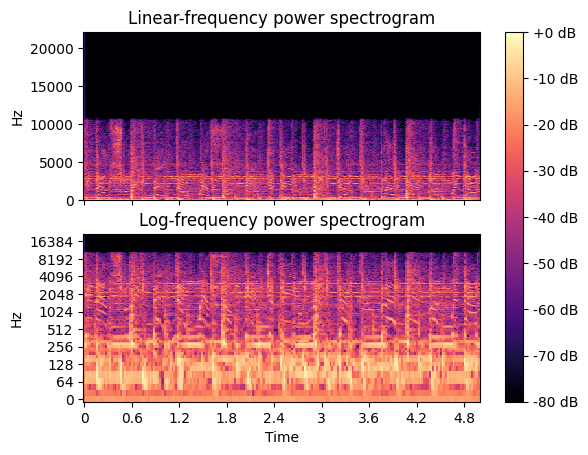

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
db = librosa.amplitude_to_db(np.abs(librosa.stft(redhot_file)), ref=np.max)
img = librosa.display.specshow(db, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
db2 = librosa.amplitude_to_db(np.abs(librosa.stft(redhot_file, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(db2, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()

fig.colorbar(img, ax=ax, format="%+2.f dB")

time shift:  -10120


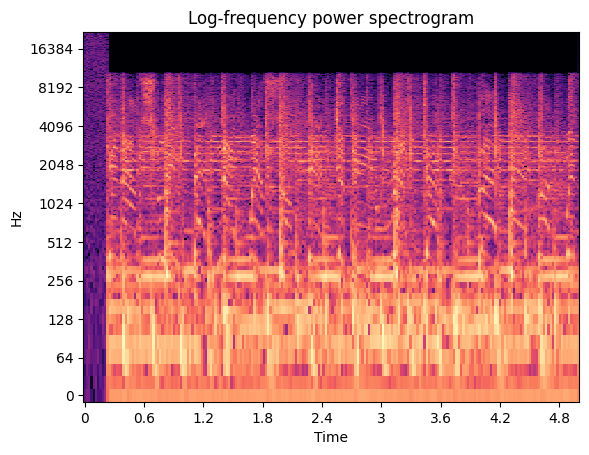

In [7]:
# time shift - introduces noise to change the start point of file
start_ = int(np.random.uniform(-30000,30000))
print('time shift: ',start_)
if start_ >= 0:
    wav_time_shift = np.r_[redhot_file[start_:], np.random.uniform(-0.01,0.01, start_)]
else:
    wav_time_shift = np.r_[np.random.uniform(-0.01,0.01, -start_), redhot_file[:start_]]

plot_spectrogam(hop_length=1024, file=wav_time_shift)
ipd.Audio(wav_time_shift, rate=sr)

In [9]:
# changing the speed rate and the pitch (proportionally)

rng = np.random.default_rng()
speed_rate = rng.uniform(low=0.7, high=1.3)

wav_speed_tune = cv2.resize(redhot_file, (1, int(len(redhot_file) * speed_rate))).squeeze()
print('speed rate: %.3f' % speed_rate, '(lower is faster)')
if len(wav_speed_tune) < len(redhot_file):
    pad_len = len(redhot_file) - len(wav_speed_tune)
    wav_speed_tune = np.r_[rng.uniform(-0.001,0.001,int(pad_len/2)),wav_speed_tune,rng.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
else: 
    cut_len = len(wav_speed_tune) - len(redhot_file)
    wav_speed_tune = wav_speed_tune[int(cut_len/2):int(cut_len/2)+1223424]
print('wav length: ', wav_speed_tune.shape[0])
ipd.Audio(wav_speed_tune, rate=sr)

speed rate: 0.803 (lower is faster)
wav length:  220500


In [11]:
# changing length without changing pitch (time stretch)

time_stretch = librosa.effects.time_stretch(y=redhot_file, rate=1.2)
ipd.Audio(time_stretch, rate=sr)

In [69]:
# frequency filters

f0 = 27.5
cents = range(0,11500,300) # Until 19KHz 300 cents = minor 3rd filters
fil_freq = np.round([f0*(pow((2**((1.0/1200))),i)) for i in cents])
print(len(fil_freq))

# dB = 20 * np.log10(signal_fft_abs / np.max(signal_fft_abs))

39


In [121]:
    D = librosa.stft(redhot_file)
    D_mag, D_phase = librosa.magphase(D)

    # Get the frequencies corresponding to each bin
    freqs = librosa.fft_frequencies(sr=sr)

    # Find the indices of the frequency bins that lie within the desired range
    freq_bins = np.where((freqs >= low_freq) & (freqs <= high_freq))[0]

    # Apply noise to the magnitude of the specified frequency bins
    noise = np.random.randn(*D_mag.shape)
    max_noise = np.max(np.abs(noise))
    print(max_noise)
    print((10**1)*max_noise)
    # noise_dB = 20 * np.log10(noise / np.max(noise))
    # print(noise[0], noise_dB[0])
    # # print(np.min(noise), np.max(noise))
    # # p = (10**3)*np.max(noise)
    # # print(p)
    

4.6034882557058765
46.034882557058765


In [124]:
noise_level_dB =1
noise_level_linear = 10**(noise_level_dB / 20.0)
noise = np.random.randn(*D_mag.shape) * noise_level_linear
print(np.max(noise))

5.819631653236221


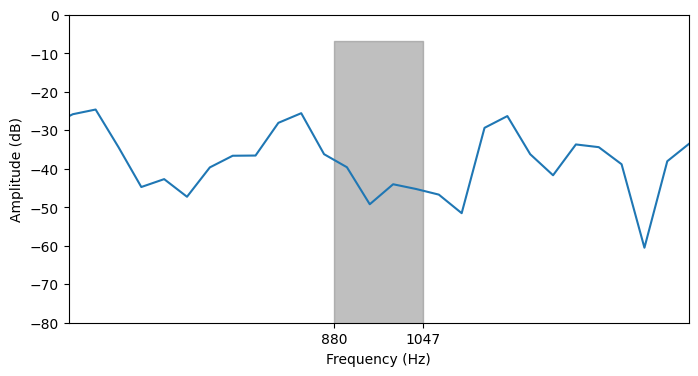

[ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116]
[3015. 3058. 3101. 3144. 3187.]


In [133]:
# extract and plot STFT - 
fourier_redhot = fourier(redhot_file)
gray_area_x = [fil_freq[20], fil_freq[21]] # minor 3rd filters
plot_fourier(signal=fourier_redhot, fft_freqs=fft_freqs, fill_area=gray_area_x, fill=True)

low_freq = 3000  # Lower bound of the frequency range in Hz
high_freq = 5000  # Upper bound of the frequency range in Hz
print(np.where((fft_freqs>= low_freq) & (fft_freqs <= high_freq))[0])
print(fft_freqs[70:75])


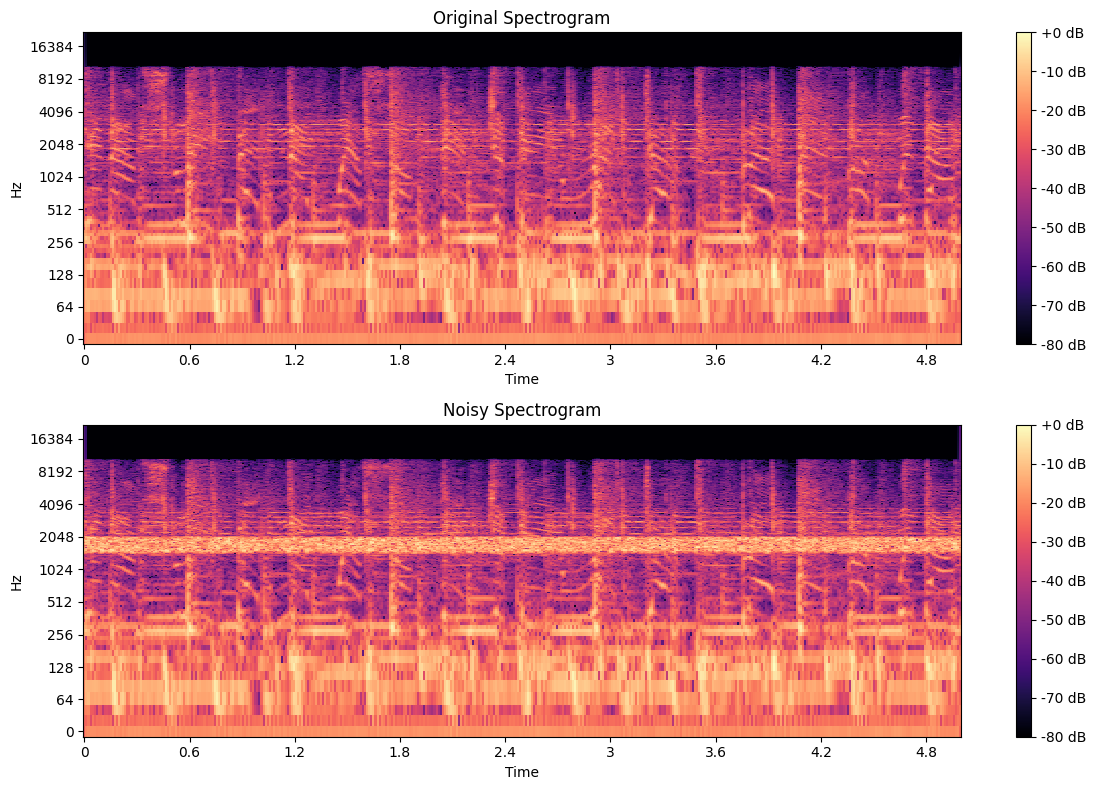

In [160]:

audio = redhot_file
sr = 44100

def apply_noise_in_frequency_range(audio, low_freq, high_freq, noise_level_dB):#, band_pass = False):
    # Perform Short-Time Fourier Transform (STFT)
    D = librosa.stft(audio, n_fft=1024, hop_length=256)
    D_mag, D_phase = librosa.magphase(D)

    # Find the indices of the frequency bins that lie within the desired range
    freq_bins = np.where((fft_freqs >= low_freq) & (fft_freqs <= high_freq))[0]

    # Convert noise level from dB to linear scale
    noise_level_linear = 10**(noise_level_dB / 20.0)

    # Apply noise to the magnitude of the specified frequency bins
    noise = np.random.randn(*D_mag.shape) * noise_level_linear
    
    D_mag[freq_bins, :] += noise[freq_bins, :]
    
    # if band_pass == False:
    #     # operator += adds noise to the original values of D_mag
    #     D_mag[freq_bins, :] += noise[freq_bins, :]
    # 
    # else:
    #     # operator = replaces the values, cutting of the frequencies in freq_bins, as a sort of band_pass filter
    #     D_mag[freq_bins, :] = noise[freq_bins, :]

    # Combine the modified magnitude with the original phase
    D_noisy = D_mag * D_phase

    # Perform the inverse STFT to convert back to the time domain
    audio_noisy = librosa.istft(D_noisy)

    return audio_noisy

# Apply noise in the specified frequency range
low_freq = 1500  # Lower bound of the frequency range in Hz
high_freq = 2000  # Upper bound of the frequency range in Hz
noise_level_dB = 30  # Adjust the noise level as needed
# freqs = fft_freqs

audio_noisy = apply_noise_in_frequency_range(audio, low_freq, high_freq, noise_level_dB)#, band_pass=True)

# Save the modified audio to a new file
output_filename = 'output_noisy.wav'
sf.write(output_filename, audio_noisy, sr)

# plot_spectrogam(hop_length=1024, file=)

# Optionally, plot the original and modified spectrograms for visualization
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
# librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio), ref=np.max),
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max),
                         sr=sr, y_axis='log', x_axis='time')
plt.title('Original Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(audio_noisy)), ref=np.max),
                         sr=sr, y_axis='log', x_axis='time')
plt.title('Noisy Spectrogram')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

# Optionally, play the modified audio (for Jupyter notebooks)
from IPython.display import Audio
Audio(data=audio_noisy, rate=sr)
